This version of the snake game allows you to implement and run your evolutionary algorithm

In [1]:
import random
import time
import turtle
import math
from datetime import datetime
import numpy as np

In [2]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)

Change headless to True when evolving your solution. You can then pickle your final solution, and run it with this set to True to visualize the result, if you wish. Note that, when using Turtle,  to run it again properly you might need to go to restart your kernel after the visualization has finished.

If you are running on the cloud, or on Google Colab, you can chose to remove the turtle and display code altogether and only run headless. You could then pickle your best solution and use this code to see it play.

In [3]:
HEADLESS = False

In [4]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        #self.win.screensize((XSIZE*20)+20,(YSIZE*20)+20)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color("green")
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [5]:
class snake:
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0] ]# Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.ahead = []
        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        if self.snake[0] == self.food:                                            # When snake eats the food
            return True
        else:    
            last = self.snake.pop()  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Sensing functions       
    def is_wall(self, coordinate):
        return int(coordinate[0] == 0 or coordinate[0] == (YSIZE-1) or coordinate[1] == 0 or coordinate[1] == (XSIZE-1))
    
    def is_snake_body(self, coordinate):
        return int(coordinate in self.snake)
    
    # Inform snake the direction it needs to travel to get food (angle in radians)
    def direction_to_food(self):
        return np.array(self.food) - np.array(self.snake[0])
    
    def get_snake_direction(self):
        if(self.snake_direction == "up"):
            # Get the coordinate 0 degrees of self.snake[0]
            return np.array([-1, 0])
        elif(self.snake_direction == "right"):
            # Get the coordinate 90 degrees of self.snake[0]
            return np.array([0, 1])
        elif(self.snake_direction == "down"):
            return np.array([1, 0])
        elif(self.snake_direction == "left"):
            # Get the coordinate 270 degrees of self.snake[0]
            return np.array([0, -1])
    
    def normalize(self, snake_vector):
        return snake_vector / np.linalg.norm(snake_vector)
    
    def get_angle_to_food(self):
        snake_direction = self.get_snake_direction()
        food_direction = self.direction_to_food()
        snake_direction_vector = self.normalize(snake_direction)
        food_direction_vector = self.normalize(food_direction)
        dot_product = np.dot(snake_direction_vector, food_direction_vector)
        
        if dot_product > 1:
            dot_product = 1
        elif dot_product < -1:
            dot_product = -1
            
        angle = np.arccos(dot_product)
        if angle > np.pi:
            angle = angle - (2 * np.pi)
        return angle
       
    def is_location_to_left_blocked(self):
        if(self.snake_direction == "up"):
            # Get the coordinate -90 degrees of self.snake[0]
            coordinateLeftOfSnakeHead = [self.snake[0][0], self.snake[0][1] - 1]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateLeftOfSnakeHead) or self.is_wall(coordinateLeftOfSnakeHead))
        elif(self.snake_direction == "right"):
            # Get the coordinate 0 degrees of self.snake[0]
            coordinateLeftOfSnakeHead = [self.snake[0][0] - 1, self.snake[0][1]]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateLeftOfSnakeHead) or self.is_wall(coordinateLeftOfSnakeHead))
        elif(self.snake_direction == "down"):
            # Get the coordinate 90 degrees of self.snake[0]
            coordinateLeftOfSnakeHead = [self.snake[0][0], self.snake[0][1] + 1]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateLeftOfSnakeHead) or self.is_wall(coordinateLeftOfSnakeHead))
        elif(self.snake_direction == "left"):
            # Get the coordinate 180 degrees of self.snake[0]
            coordinateLeftOfSnakeHead = [self.snake[0][0] + 1, self.snake[0][1]]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateLeftOfSnakeHead) or self.is_wall(coordinateLeftOfSnakeHead))
    
    def is_location_to_right_blocked(self):
        if(self.snake_direction == "up"):
            # Get the coordinate 90 degrees of self.snake[0]
            coordinateRightOfSnakeHead = [self.snake[0][0], self.snake[0][1] + 1]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateRightOfSnakeHead) or self.is_wall(coordinateRightOfSnakeHead))
        elif(self.snake_direction == "right"):
            # Get the coordinate 180 degrees of self.snake[0]
            coordinateRightOfSnakeHead = [self.snake[0][0] + 1, self.snake[0][1]]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateRightOfSnakeHead) or self.is_wall(coordinateRightOfSnakeHead))
        elif(self.snake_direction == "down"):
            # Get the coordinate 270 degrees of self.snake[0]
            coordinateRightOfSnakeHead = [self.snake[0][0], self.snake[0][1] - 1]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateRightOfSnakeHead) or self.is_wall(coordinateRightOfSnakeHead))
        elif(self.snake_direction == "left"):
            # Get the coordinate 0 degrees of self.snake[0]
            coordinateRightOfSnakeHead = [self.snake[0][0] - 1, self.snake[0][1]]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateRightOfSnakeHead) or self.is_wall(coordinateRightOfSnakeHead))
    
    def is_location_ahead_blocked(self):
        if(self.snake_direction == "up"):
            # Get the coordinate 0 degrees of self.snake[0]
            coordinateAboveSnakeHead = [self.snake[0][0] - 1, self.snake[0][1]]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateAboveSnakeHead) or self.is_wall(coordinateAboveSnakeHead))
        elif(self.snake_direction == "right"):
            # Get the coordinate 90 degrees of self.snake[0]
            coordinateAboveSnakeHead = [self.snake[0][0], self.snake[0][1] + 1]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateAboveSnakeHead) or self.is_wall(coordinateAboveSnakeHead))
        elif(self.snake_direction == "down"):
            # Get the coordinate 180 degrees of self.snake[0]
            coordinateAboveSnakeHead = [self.snake[0][0] + 1, self.snake[0][1]]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateAboveSnakeHead) or self.is_wall(coordinateAboveSnakeHead))
        elif(self.snake_direction == "left"):
            # Get the coordinate 270 degrees of self.snake[0]
            coordinateAboveSnakeHead = [self.snake[0][0], self.snake[0][1] - 1]
            # check if that coordinate is the wall or part of the snake and return false if it is else return true
            return int(self.is_snake_body(coordinateAboveSnakeHead) or self.is_wall(coordinateAboveSnakeHead))
        
    def is_food_directly_in_front(self):
        if(self.snake_direction == "up"):
            return int((self.snake[0][0] < self.food[0]) and (self.snake[0][1] == self.food[1]))
        elif(self.snake_direction == "right"):
            return int((self.snake[0][0] == self.food[0]) and (self.snake[0][1] < self.food[1]))
        elif(self.snake_direction == "down"):
            return int((self.snake[0][0] > self.food[0]) and (self.snake[0][1] == self.food[1]))
        elif(self.snake_direction == "left"):
            return int((self.snake[0][0] == self.food[0]) and (self.snake[0][1] > self.food[1]))
        
    def is_food_directly_to_the_left(self):
        if(self.snake_direction == "up"):
            return int((self.snake[0][0] == self.food[0]) and (self.snake[0][1] > self.food[1]))
        elif(self.snake_direction == "right"):
            return int((self.snake[0][0] > self.food[0]) and (self.snake[0][1] == self.food[1]))
        elif(self.snake_direction == "down"):
            return int((self.snake[0][0] == self.food[0]) and (self.snake[0][1] < self.food[1]))
        elif(self.snake_direction == "left"):
            return int((self.snake[0][0] < self.food[0]) and (self.snake[0][1] == self.food[1]))
        
    def is_food_directly_to_the_right(self):
        if(self.snake_direction == "up"):
            return int((self.snake[0][0] == self.food[0]) and (self.snake[0][1] < self.food[1]))
        elif(self.snake_direction == "right"):
            return int((self.snake[0][0] < self.food[0]) and (self.snake[0][1] == self.food[1]))
        elif(self.snake_direction == "down"):
            return int((self.snake[0][0] == self.food[0]) and (self.snake[0][1] > self.food[1]))
        elif(self.snake_direction == "left"):
            return int((self.snake[0][0] > self.food[0]) and (self.snake[0][1] == self.food[1]))

In [6]:
snake_game = snake(XSIZE,YSIZE)

In [7]:
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)

In [8]:
def run_game(AIBrain, display,snake_game, headless):

    score = 0
    timeOfSurvival = 0
    timeSinceFoodWasLastEaten = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False
    snake_direction = "right"

    while not game_over:

        # ****YOUR AI BELOW HERE******************
        # Pass in values which will be used as the input nodes in the neural network
        output = AIBrain.feedForward([snake_game.get_angle_to_food(), snake_game.is_location_to_left_blocked(), snake_game.is_location_to_right_blocked(), snake_game.is_location_ahead_blocked(), snake_game.is_food_directly_in_front(), snake_game.is_food_directly_to_the_left(), snake_game.is_food_directly_to_the_right()])
        
        # Hold on to information regarding which way the snake is facing
        previous_snake_direction = snake_game.snake_direction
        
        # Choose decision with the largest value
        decision = np.argmax(output, axis=0)
        
        # Map decision made to a direction of which the snake will travel (relative to the direction it is heading)
        if decision == 0:
            if previous_snake_direction == "up":
                snake_game.snake_direction = "left"
            elif previous_snake_direction == "right":
                snake_game.snake_direction = "up"
            elif previous_snake_direction == "left":
                snake_game.snake_direction = "down"
            elif previous_snake_direction == "down":
                snake_game.snake_direction = "right"
        if decision == 1:
            if previous_snake_direction == "up":
                snake_game.snake_direction = "right"
            elif previous_snake_direction == "right":
                snake_game.snake_direction = "down"
            elif previous_snake_direction == "left":
                snake_game.snake_direction = "up"
            elif previous_snake_direction == "down":
                snake_game.snake_direction = "left"
        if decision == 2:
            if previous_snake_direction == "up":
                snake_game.snake_direction = "up"
            elif previous_snake_direction == "right":
                snake_game.snake_direction = "right"
            elif previous_snake_direction == "left":
                snake_game.snake_direction = "left"
            elif previous_snake_direction == "down":
                snake_game.snake_direction = "down"
        if decision == 3:
            if previous_snake_direction == "up":
                snake_game.snake_direction = "down"
            elif previous_snake_direction == "right":
                snake_game.snake_direction = "left"
            elif previous_snake_direction == "left":
                snake_game.snake_direction = "right"
            elif previous_snake_direction == "down":
                snake_game.snake_direction = "up"
        
        timeOfSurvival += 1
        
        # ****YOUR AI ABOVE HERE******************
        
        # Before updating snake position check if there are any possible moves left
        if len(snake_game.snake) == XSIZE * YSIZE:
            game_over = True
            print("Snake has completed the game")
        
        snake_game.update_snake_position()

        # Check if food is eaten
        if snake_game.food_eaten():
            snake_game.place_food()
            score += 1
            timeSinceFoodWasLastEaten = 0
            if not headless: display.add_snake_segment()
        else:
            timeSinceFoodWasLastEaten += 1
        
        # Game over if snake takes too long to eat food
        if timeSinceFoodWasLastEaten == 100:
            game_over = True
            print("Snake has taken too long to eat food")

        # Game over if the snake runs over itself
        if snake_game.snake_turns_into_self():
            game_over = True
            print("Snake turned into itself!")

        # Game over if the snake goes through a wall
        if snake_game.snake_hit_wall():
            game_over = True
            print("Snake hit a wall!")

        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.2) # Change this to modify the speed the game runs at when displayed.
    
    print("\nFINAL score - " + str(score))
    if not headless: turtle.done()
    return score, timeOfSurvival


# Defining neural network Class

### Code for neural network has been taken from EVCO practicals and was orginally written by Daniel Franks [1]

In [9]:
# This MLP class is taken from the postworkshop_6B_discussion python file [1]
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node from input to hidden layer 1
        self.numHidden1 = numHidden1 
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1 + 1) # Add bias from hidden layer 1 to hidden layer 2
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2 + 1)   # Add bias from hidden layer 2 to output layer

        self.ReLU = lambda x : max(0,x)
    
    def softmax(self, x):
        ans = np.exp(x - np.max(x))
        return ans/ans.sum()
    
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)             # Add bias input
        
        h1 = np.dot(self.w_i_h1, inputsBias)         # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1
        h1.append(1)                                 # Add bias to hidden layer 1                     
        
        h2 = np.dot(self.w_h1_h2, h1)                # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2
        h2.append(1)                                 # Add bias to hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        return self.softmax(output)                  # Activate output layer

    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o )

    def setWeightsLinear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * (self.numHidden1 + 1)
        numWeights_H2_O = self.numOutput * self.numHidden2

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))
        
        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2 + numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1 + 1))
        
        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2 + 1))

[1] D. Franks, postworkshop_6B_discussion. [Online]. Available: https://vle.york.ac.uk/webapps/blackboard/content/listContent.jsp?course_id=_98201_1&content_id=_3927818_1&mode=reset. [Accessed: 21 Mar. 2021].

# My genetic algorithm

In [10]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

In [11]:
numInputNodes = 7 # Number of input nodes
numHiddenNodes1 = 5 # Number of nodes in hidden layer 1
numHiddenNodes2 = 5 # Number of nodes in hidden layer 2
numOutputNodes = 4 # Number of ouput nodes, one for up, one for right, one for left

# Number of connections
IND_SIZE = ((numInputNodes + 1) * numHiddenNodes1) + ((numHiddenNodes1 + 1) * numHiddenNodes2) + ((numHiddenNodes2 + 1) * numOutputNodes)

neuralNetwork = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

In [12]:
# Keep track of the snake with the highest score
bestScore = 0
leastAmountOfStepsTakenToGetBestScore = 0

In [13]:
import pickle

def saveBestSnake(bestSnake):
    outputfile = open("bestSnake", "wb+")
    pickle.dump(bestSnake, outputfile)
    outputfile.close()

In [14]:
# Defining custom evaluation function
def evaluate(individual):
    global bestScore
    global leastAmountOfStepsTakenToGetBestScore
    neuralNetwork.setWeightsLinear(individual)
    snake_game.reset()
    score,timeOfSurvival = run_game(neuralNetwork, display, snake_game, headless=True)
    # Saving the best snake generated throughout, I found this to be the best way to save the best snake as
    # tool.selBest does not do the trick when it comes to multi objective evolutionary algorithms
    if(score > bestScore):
        bestScore = score
        leastAmountOfStepsTakenToGetBestScore = timeOfSurvival
        saveBestSnake(individual)
    elif(score == bestScore and timeOfSurvival < leastAmountOfStepsTakenToGetBestScore):
        leastAmountOfStepsTakenToGetBestScore = timeOfSurvival
        saveBestSnake(individual)
    return score, timeOfSurvival

In [15]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

In [16]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selNSGA2)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [17]:
def pareto_eq(ind1, ind2):
    return np.allclose(ind1.fitness.values, ind2.fitness.values)

In [18]:
NGEN = 100
popSize = MU = 200
LAMBDA = 400
CXPB = 0.9
MUTPB = 0.1

pop = toolbox.population(n=popSize)
hof = tools.ParetoFront(similar=pareto_eq)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [19]:
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)


Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL sc

Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0


Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0

Snake has taken too long to eat food

FINAL score - 2
Snake hit a wall!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itsel

Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turn

Snake has taken too long to eat food

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into its

Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake h

Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned in

Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL s

Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Sn

Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake h

Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat fo

Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
8  	400   	[  1.78  102.245]	[ 3.32138525 49.03503824

Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wal

Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wal

Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itse

Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINA

Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Sna

Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 8
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL 

Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!


Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 3
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score

Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
14 	400   	[  6.365 144.65 ]	[ 4.34186308 65.38507093]	[ 1. 65.]	[ 20. 463.]
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

F

Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 3
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!



Snake turned into itself!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!


Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL 

Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit

Snake hit a wall!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 12
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 8
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!



Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1


Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 7
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score -

19 	400   	[ 10.8  221.85]  	[ 4.31740663 79.79246518]	[  1. 102.]	[ 23. 468.]
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake has taken too long to eat food

FINAL score - 0
Snake hit a 

Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit

Snake hit a wall!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FIN

Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into its

Snake has taken too long to eat food

FINAL score - 3
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit 

22 	400   	[ 12.435 259.76 ]	[ 4.21968897 80.42078338]	[  2. 122.]	[ 24. 545.]
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 3
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Sna

Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 

Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itse

Snake turned into itself!

FINAL score - 16
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL sco

Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Sn

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 12
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake hit 

Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 23
Snake has taken too long to eat food

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 6
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit

Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 14
Snake has taken too long to eat food

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake hit a 

Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 

Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL sco

Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 8
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 3
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL s

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wal

Snake hit a wall!

FINAL score - 4
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake 

Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 9
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score 

Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 13
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
30 	400   	[ 18.53 412.88]  	[ 2.93753298 79.16555817]	[ 10. 256.]	[ 34. 928.]
Snake has taken too long to eat food

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a 

Snake has taken too long to eat food

FINAL score - 3
Snake hit a wall!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 15
Snake has taken too long to eat food

FINAL score - 4
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 22
Snake turne

Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall

Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 7
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 12
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake 

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 20
Snake turned into itself!


Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 7
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 3
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Sn

Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score 

Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 10
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 7
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINA

Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 9
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned int

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 25
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 

Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FI

Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned in

Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL 

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 11
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 23
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL 

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 21
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken t

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score

Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 6
Snake hit a wall!

FINAL score - 9
Snake turned into itself!

FINAL score - 22
Snake has taken too long to eat food

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 5
Snake turned into itself!

FINAL score - 0
Snake turned in

Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 4
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake hit a wall!


Snake turned into itself!

FINAL score - 25
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 11
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 11
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score 


FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 3
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score 

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 10
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 16
Snake

Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned in

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL scor

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22

Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 5
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 17
Snake turn

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turn

Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINA

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 26
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL

Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 20
Snake has taken too long to eat food

FINAL score - 6
Snake t

Snake turned into itself!

FINAL score - 21
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 8
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score -

Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 7
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 12
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0


Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINA

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 14
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 4
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 1

Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL score - 1

Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 25
Snake has taken t

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 13
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL scor

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 5
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL 

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 12
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 3
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itsel

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 21
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake turned into i

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 1
Snake turne

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 12
Snake turned into itself!



Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 18
Snake turned into

Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 2
Snake turned 

Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 18
Snake hit a w

Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 20
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 15
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!



Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 7
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 20
Snake turned in

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 0
Snake hit a wal

Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL sco

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake has taken too long 

Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL 

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 6
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
S

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 4
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 27
Snake turned into 

Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 11
Snake 

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 9
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 8
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINA

Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 13
Snake turned in

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!



Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 16
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 11
Snake

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 24
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 3


Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6


Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 18
Sn

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 8
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 9
Snake has taken too long to eat food

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 

Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 8
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snak

Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake tur

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINA

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake t

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 4
Snake turned into itself!

FINAL score - 24
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itse

Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake t

Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake h

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 3
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 8
Snake has taken too long to eat food

FINAL score - 3
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 16
Snake hit a wall!


Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL sc

Snake turned into itself!

FINAL score - 20
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 9
Snake has taken too long to eat food

FINAL score - 4
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 22
Snake turned in

Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake has taken too long to eat food

FINAL score - 7
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 5
Snake turned into itself!

FINAL score - 21
Snake turned into it

Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 15
Snake turned into itself!

FINAL score - 16
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
S

Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 24
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itse

Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 4
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake turned into itself!


Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL

Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FIN

Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 6
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 13
Snake tu

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 7
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 25
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake tur

Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake has taken too long to eat food

FINAL score

Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 26
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 20
Snake turned into itself!


Snake hit a wall!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake turned into

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake has taken too long to eat food

FINAL score - 5
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 6
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FIN

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

F

Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 23
Snake

Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 16
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score 

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 8
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 6
Sn

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 6
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 12
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL scor

Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 7
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!



Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 26
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 8
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 11
Snake turned into itself!

FINAL score - 1

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 2

Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!



Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 25
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itse

Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL s

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 26
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 13
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake has taken too lo

Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 1

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 4
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake turned into 

Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FIN

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 19
Snak

Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 24
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 10
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 26
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 9
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 16
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL sco

Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 13
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 13
Snake turned into itsel

Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 3
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 3
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 10
Snake turned into it

Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 4
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 3
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 13
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 25
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL sco

Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
S

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 18
Snake has taken too long to eat food

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

F

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 16
Snake has taken too long to eat food

FINAL score - 3
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake t

Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 4
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 25
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into 

Snake has taken too long to eat food

FINAL score - 7
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake tu

Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 2
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 15
Snake has taken too long to eat food

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned i

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 11
Snake has taken too long to eat food

FINAL score - 3
Snake turned into itself!

FINAL score - 24
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 10
Snake turned into itsel

Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 1
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 10
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake turned into it

Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 26
Snake turned into itself!

FINAL score - 20
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL scor

Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 2
S

Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 11
Snake tu

Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 7
Snake has taken too long to eat food

FINAL score - 15
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL sc

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 7
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 1

Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 9
Snake turned into itself!

FINAL score - 5
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 6
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 24
Snake hit a wall!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into i

Snake turned into itself!

FINAL score - 27
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 13
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 0
Snake tu

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 22
Snake tur

Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 19
Snake has taken too long to eat food

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake has taken

Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 14
Snake hit a wall!

FINAL score - 6
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 5
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 3
Snake turned into itself!

FINAL score - 22

Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 11
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 1
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 12
Snake hit a wall!

FINAL score - 1
Snake hit a wall!

FINAL score - 4
Snake hit a wall!

FINAL score - 4
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 19
Snake turn

Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 14
Snake has taken too long to eat food

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 1
Snake hit a wa

Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 15
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 2
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 14
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 5
Snake turned into itself!

FINAL score - 1
Snake turned into itsel

Snake turned into itself!

FINAL score - 11
Snake hit a wall!

FINAL score - 5
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake has taken too long to eat food

FINAL score - 10
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 0
95 	400   	[ 24.775 604.65 ]	[ 3.2533636

Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 13
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 7
Snake has taken too long to eat food

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL 

Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 12
Snake has taken too long to eat food

FINAL score - 9
Snake turned into itself!

FINAL score - 26
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 11
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake has taken too long to eat food

FINAL score - 1
96 	400   	[ 24.78  604.985]	[ 3.25447384 78.35626826]	[ 11. 438.]	[ 34. 999.]
Snake turned into itself!

FINAL score - 10
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 8
Snake has taken too long to eat food

FINAL score - 10
Snake hit a wall!

FINAL score - 0
Snake turned into its

Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 18
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake hit a wall!

FINAL score - 6
Snake hit a wall!

FINAL score - 12
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 21
Snake turned into it

Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake has taken too long to eat food

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 2
Snake turned into itself!

FINAL score - 22
Snake turned into itself!

FINAL score - 1
97 	400   	[ 24.79  607.775]	[ 3.31298959 79.44598401]	[ 11. 438.]	[ 34. 999.]
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 19
Snake hit a wall!


Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake has taken too long to eat food

FINAL score - 3
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 25
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake turned into itself!

FINAL score - 7
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 8
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score -

98 	400   	[ 24.7   612.675]	[ 3.58887169 81.03449497]	[ 11. 470.]	[ 34. 999.]
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 15
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 4
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 16
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score

Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 3
Snake turned into itself!

FINAL score - 23
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 27
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 21
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 24
Snake turned into itself!

FINAL score - 8
Snake turned into itself!

FINAL score - 19
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 10
Snake turne

Snake turned into itself!

FINAL score - 21
Snake has taken too long to eat food

FINAL score - 1
Snake turned into itself!

FINAL score - 0
Snake turned into itself!

FINAL score - 22
Snake hit a wall!

FINAL score - 3
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 2
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 5
Snake hit a wall!

FINAL score - 4
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 12
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 19
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL sco

Snake turned into itself!

FINAL score - 16
Snake turned into itself!

FINAL score - 24
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 20
Snake turned into itself!

FINAL score - 5
Snake turned into itself!

FINAL score - 26
Snake turned into itself!

FINAL score - 18
Snake turned into itself!

FINAL score - 17
Snake turned into itself!

FINAL score - 17
Snake hit a wall!

FINAL score - 17
Snake turned into itself!

FINAL score - 14
Snake turned into itself!

FINAL score - 21
Snake hit a wall!

FINAL score - 17
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 9
Snake turned into itself!

FINAL score - 2
Snake turned into itself!

FINAL score - 20
Snake hit a wall!

FINAL score - 0
Snake hit a wall!

FINAL score - 0
Snake turned into itself!

FINAL score - 0
Snake hit a wall!

FINAL score - 7
Snake hit a wall!

FINAL score - 0
Snake turned into itself!



# Plot statistics

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = log.select("gen")
_min = log.select("min")
_max = log.select("max")
avgs = log.select("avg")
stds = log.select("std")

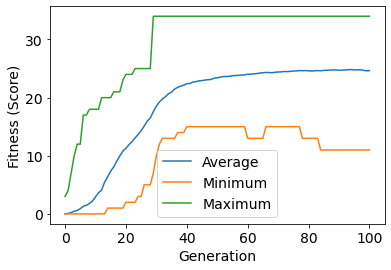

In [21]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

avgs_score = [item[0] for item in avgs]
_min_score = [item[0] for item in _min]
_max_score = [item[0] for item in _max]

fig1, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs_score, label="Average")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness (Score)")

line2 = ax1.plot(gen, _min_score, label="Minimum")
line3 = ax1.plot(gen, _max_score, label="Maximum")
ax1.legend()

# Get the best individual and watch them play

In [22]:
def getBestSnake():
    file = open("bestSnake", "rb")
    bestSnake = pickle.load(file)
    file.close()
    return bestSnake

In [23]:
bestSnake = getBestSnake()

### Restart Kernel here if needed (need to compile classes above)

In [24]:
display = DisplayGame(XSIZE,YSIZE)

In [ ]:
bestSnake = getBestSnake()

neuralNetwork.setWeightsLinear(bestSnake)

snake_game = snake(XSIZE,YSIZE)
snake_game.reset()

score, timeOfSurvival = run_game(neuralNetwork, display, snake_game, headless=False)

Snake hit a wall!

FINAL score - 24
